# A 2D, viscoplastic shallow ice shelf model

## Problem description

Shearing sidewalls induce rumples near the downstream corners. 

## Governing equations

Consider a 2D floating ice shelf, flowing viscously in accordance with the SSA, with depth-averaged velocity $u$ and net depth-integrated stress of $H\overline{\sigma}$, with a viscoplastic deflection $\eta$ (and associated rate $\dot{\eta}$) and bending moment $M$ resulting in a nonzero height above buoyancy, $h_{ab}$. The shelf will melt backward from the front at exactly the flow rate, which will save us having to track the ice front progression. At each timestep, the shelf obeys the equations below, which slightly modifies the treatment in [Macayeal et al. (2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3):

$$\nabla\cdot\nabla\cdot \mathbf{M} - \rho_wgh_{ab} + \nabla\nabla\eta:H\overline{\boldsymbol{\sigma}} = 0$$
$$\kappa\mathbf{M} + C\nabla\nabla\dot{\eta} + Ctr(\nabla\nabla\dot{\eta})\mathbf{I}= 0$$

where I've defined the flexural viscosity $C := \frac{\nu H^3}{6}$, and $\kappa$ is a scalar designed to add plastic rheology to the otherwise purely-viscous constitutive relation (see the definition of $\kappa$ given below, and also Appendix A from Bezu et al., 2024 for more detail). The equations above can be rewritten in terms of the depth-invariant part of the flexural stress, $\boldsymbol{\tau}_{\dot{\eta}/\zeta} := -2\overline{\nu}\nabla\nabla\dot{\eta}$. For brevity, let $\boldsymbol{\tau}_{\dot{\eta}/\zeta}^* := \boldsymbol{\tau}_{\dot{\eta}/\zeta} + tr(\boldsymbol{\tau}_{\dot{\eta}/\zeta})\mathbf{I}$. Then

$$\nabla\cdot\nabla\cdot\left(\frac{1}{12}H^3\boldsymbol{\tau}_{\dot{\eta}/\zeta}^*\right) - \rho_wgh_{ab} + \nabla\nabla\eta : H\overline{\boldsymbol{\sigma}} = 0 $$

$$\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta} + 2\overline{\nu}\nabla\nabla\dot{\eta} = 0.$$

The scalar $\kappa$ is defined as

$$\kappa = \begin{cases}
1 & J_{II}\left(\boldsymbol{\tau}_{\dot{\eta}/\zeta}\right) \leq \tau_c\\
\frac{\tau_c + \alpha\left(J_{II}\left(\boldsymbol{\tau}_{\dot{\eta}/\zeta}\right) - \tau_c\right)}{J_{II}\left(\boldsymbol{\tau}_{\dot{\eta}/\zeta}\right)} & J_{II}\left(\boldsymbol{\tau}_{\dot{\eta}/\zeta}\right) > \tau_c.
\end{cases}
$$

Here $0 \leq \alpha \leq 1$ is a tunable parameter that allows us to control how "sharply" the bending moment upper bound is imposed. For example, if $\alpha = 0$, then whenever $J_{II} > \tau_c,$ there is a sharp cap imposed on $\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}$, with $J_{II}\left(\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}\right) = J_{II}\left(\frac{\tau_c}{J_{II}(\boldsymbol{\tau}_{\dot{\eta}/\zeta})}\boldsymbol{\tau}_{\dot{\eta}}^*\right) = \frac{\tau_c}{J_{II}(\boldsymbol{\tau}_{\dot{\eta}/\zeta})}J_{II}(\boldsymbol{\tau}_{\dot{\eta}/\zeta}) = \tau_c$. At the other extreme, if $\alpha = 1$, then $J_{II}(\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}) = J_{II}(\boldsymbol{\tau}_{\dot{\eta}/\zeta})$ everywhere. For values in between, $J_{II}(\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta})$ is scaled linearly whenever $\tau_c$ is exceeded, so that any growth beyond $\tau_c$ is somewhat dampened. The motivation for this scaling parameter is that the solver often fails when sharp kinks appear in $\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}$, but converges with more moderate values of $\alpha$. 


## Solution strategy

We will first model the system toward steady state geometry and velocity using functionality from icepack, and then solve the above equations iteratively from that steady-state starting point. Let superscripts denote the solution at a given timestep. Then the $t$th solution will be approximated by solving for $\boldsymbol{\tau}_{\dot{\eta}/\zeta}$ and the present rate of viscous deflection, $\dot{\eta}$:

$$\nabla\cdot\nabla\cdot\frac{1}{12}H^3\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{*(t)} - \rho_wg\left(h_{ab}^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right) + \nabla\nabla\left(\eta^{(t - 1)} + \dot{\eta}^{(t)}\Delta t\right):H\overline{\boldsymbol{\sigma}} = 0$$
$$\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{(t)} + 2\overline{\nu}\nabla\nabla\dot{\eta}^{(t)} = 0$$

After solving this system, we update the surface and basal elevations $s$  $b$, and then advect all quantities along with flow before beginning the next iteration. To solve the advection problems we use [TransportEquation and TransportSolver](https://github.com/chrismiele/weird_flex/blob/main/flow/transport_solver_1D.ipynb), which will soon be incorporated into icepack.

## Variational form

Let $\dot{n} = \dot{n}(x, y)$ and $\mathbf{t} = \mathbf{t}(x, y)$ be arbitrary scalar and tensor functions on the domain $\Omega$. It can be derived that the weak forms of the two steps above are (excluding boundary terms):

$$-\int_\Omega\nabla\cdot\frac{1}{12}H^3\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{*(t)}\cdot\nabla\dot{n} - \int_\Omega \dot{n}\rho_wg\dot{\eta}^{(t)}\Delta t - \int_\Omega \nabla(\dot{\eta}^{(t)}\Delta t)\cdot\nabla\cdot \left(\dot{n}H\overline{\boldsymbol{\sigma}}\right) = \int_\Omega \dot{n}\rho_wgh_{ab}^{(t - 1)} + \int_\Omega\nabla\eta^{(t - 1)}\cdot\nabla\cdot\left(\dot{n}H\overline{\boldsymbol{\sigma}}\right)$$

$$\int_\Omega\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{(t)}:\mathbf{t} - \int_\Omega\nabla\dot{\eta}^{(t)}\cdot\nabla\cdot \left(2\overline{\nu}\mathbf{t}\right)  = 0$$

## Boundary conditions

At the terminula boundary, we use the flexure associated with the buoyancy moment of the terminal cliff, as explored by [Reeh (1968)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/on-the-calving-of-ice-from-floating-glaciers-and-ice-shelves/0E16F201FB4FF676826078C7C5F487DE). The boundary conditions for this problem are below:

- At the upstream boundary to the left, denoted $\Gamma(1)$, assume that grounding line acts as a hinge, permitting neither deflection nor bending stress. Then $\eta^{(t)} = \boldsymbol{\tau}_{\dot{\eta}/\zeta}^{(t)} = 0$ on $\Gamma(1)$ at every timestep. We enforce these using ```DirichletBC```.
- Also at the terminal cliff, we'll also enforce a downward deflection consistent with observations of buoyancy-induced flexure. 

In [1]:
nx, ny = 360, 240 #grid resolution (m)
T = 273.15 #temperature (K); freezing is 273.15
τ_c = 10 #critical stress threshold for plastic deflection
coeff = 0.05 #friction coefficient. Value from shared simulations is 0.05

saved_arrays_path = '/home/firedrake/H3F/numpy_arrays/' #the path where any existing steady-state flow solutions have already been saved
transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/marginal_rumples/' #where figures will be saved

## Imports

In [2]:
# %%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
norm = colors.TwoSlopeNorm(vcenter = 0)
import numpy as np
from operator import itemgetter
import os
import tqdm

# !pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

importing Jupyter notebook from transport_solver.ipynb


## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
H_gl = 500 #grounding line thickness in meters
year = icepack.constants.year #number of seconds in a year
u_gl = 50 #grounding line velocity boundary condition in meters per year
A = icepack.rate_factor(Constant(T)) 

## Meshing 

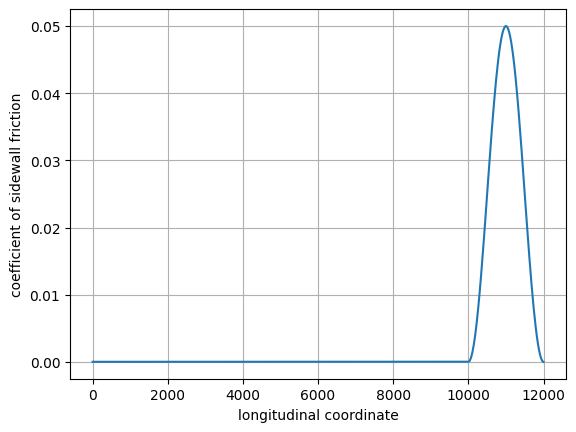

In [4]:
nx, ny = nx, ny #number of nodes
Lx, Ly = 12000, 8000 #length of domain
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}_{u_gl}_{coeff}') #identify mesh by resolution and temperature

Δt = 1 #timestep 
num_years = 200 #choose how many years to model
num_timesteps = int(num_years/Δt) + 1 #number of timesteps
deg = 1

Q = FunctionSpace(mesh, 'CG', deg)
S = TensorFunctionSpace(mesh, 'CG', deg)
QS = Q*S #mixed function space for (η, M)

q = Function(QS)
η_dot, τ_η = split(q) #trial functions for the deflection or rate and moment
n_dot, t = TestFunctions(QS) #test functions
Δη = Function(Q) #empty function to hold each step's deflection update
η_prev = Function(Q) #and the previous net deflection from the previous timestep

V = VectorFunctionSpace(mesh, 'CG', deg)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

detach, δ = Lx - 1000, 1000
friction = coeff*(0.5*cos(pi*(x - detach)/δ) + 0.5)
friction = conditional(x > detach + δ, 0, friction)
friction = Function(Q).project(conditional(x < detach - δ, 0, friction))

# friction = Function(Q).project(friction) #for simpler problems

plt.figure()
plt.plot(friction.at(X, tolerance = 1e-10))
plt.ylabel('coefficient of sidewall friction')
plt.xlabel('longitudinal coordinate')
plt.grid()

## Initialize SSA solver

In [5]:
#####################################
######################################
### initialize values to be solved ###
######################################
######################################

os.chdir(saved_arrays_path) #location of the transport solver notebook

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation

ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

from icepack.constants import glen_flow_law as n
# from icepack.models.viscosity import viscosity_depth_averaged

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    flow_n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min)
    ν = 1/2*A**(-1/flow_n)*ε_e**(1/flow_n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Spin up to steady state (or load saved geometry)

In [6]:
try: #load stead state velocity and thickness profile, if this has already been saved:
    
    with CheckpointFile(f"checkpoint_file_{nx}_{T}_{u_gl}_{coeff}.h5", 'r') as afile:
        mesh = afile.load_mesh(f'my_mesh_{nx}_{T}_{u_gl}_{coeff}')
        s_0 = afile.load_function(mesh, f'surface_{nx}_{T}_{u_gl}_{coeff}')
        H_0 = afile.load_function(mesh, f'thickness_{nx}_{T}_{u_gl}_{coeff}')
        u_0 = afile.load_function(mesh, f'velocity_{nx}_{T}_{u_gl}_{coeff}')

    s_0 = Function(Q).project(s_0)
    H_0 = Function(Q).project(H_0)
    u_0 = Function(V).project(u_0)
    
    u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = friction, 
                                     thickness = H_0, surface = s_0, fluidity = Constant(A))
    
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation

except:

###############################
###############################
### spin up to steady state ###
###############################
###############################

    residence_time = int(Lx/u_gl/4) #estimated number of years for grounding line ice to reach the terminus
    dt = 1 #set the timestep to one tenth of a year
    u_0 = u_gl*(1 - ((y - Ly/2)/(Ly/2))**4)
    u_0 = u_gl
    u_0 = Function(V).project(as_vector((u_0, 1e-50)))
    
    for step in tqdm.trange(int(residence_time/dt)):
        
        u_0 = flow_solver.diagnostic_solve(velocity = u_0, side_friction = friction,
                                         thickness = H_0, surface = s_0, fluidity = Constant(A))
        H_0 = flow_solver.prognostic_solve(dt, thickness = H_0, velocity = u_0,
                                         thickness_inflow = H_0, accumulation = Constant(0))
        s_0 = Function(Q).project((1 - ϱ)*H_0) #initial surface elevation
    
    s_0 = Function(Q, name = f'surface_{nx}_{T}_{u_gl}_{coeff}').project(s_0)
    H_0 = Function(Q, name = f'thickness_{nx}_{T}_{u_gl}_{coeff}').project(H_0)
    u_0 = Function(V, name = f'velocity_{nx}_{T}_{u_gl}_{coeff}').project(u_0)
    b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation

    with CheckpointFile(f'checkpoint_file_{nx}_{T}_{u_gl}_{coeff}.h5', 'w') as afile:
        afile.save_mesh(mesh)  # optional
        afile.save_function(s_0)
        afile.save_function(H_0)
        afile.save_function(u_0)

100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [30:37<00:00, 30.63s/it]


Error: error code 76
[0] PetscObjectDelayedDestroy() at /home/firedrake/petsc/src/sys/objects/garbage.c:78
[0] PetscObjectDestroy() at /home/firedrake/petsc/src/sys/objects/destroy.c:51
[0] PetscViewerDestroy() at /home/firedrake/petsc/src/sys/classes/viewer/interface/view.c:94
[0] PetscViewerFlush() at /home/firedrake/petsc/src/sys/classes/viewer/interface/flush.c:21
[0] PetscViewerFlush_HDF5() at /home/firedrake/petsc/src/sys/classes/viewer/impls/hdf5/hdf5v.c:116
[0] Error in external library
[0] Error in HDF5 call H5Fflush() Status -1

Exception ignored in: 'petsc4py.PETSc.Object.__dealloc__'
Traceback (most recent call last):
  File "/tmp/ipykernel_23693/3619178741.py", line 45, in <module>
petsc4py.PETSc.Error: error code 76
[0] PetscObjectDelayedDestroy() at /home/firedrake/petsc/src/sys/objects/garbage.c:78
[0] PetscObjectDestroy() at /home/firedrake/petsc/src/sys/objects/destroy.c:51
[0] PetscViewerDestroy() at /home/firedrake/petsc/src/sys/classes/viewer/interface/view.c:94
[0] PetscViewerFlush() at /home/firedrake/petsc/src/sys/classes/viewer/interface/flush.c:21
[0] PetscViewerFlush_HDF5() at /home/firedrake/petsc/src/sys/classes/viewer/impls/hdf5/hdf5v.c:116
[0] Error in external library
[0] Error in HDF5 call H5Fflush() Status -1


## Plot the initial steady-state geometry

Text(0, 0.5, 'lateral coordinate (m)')

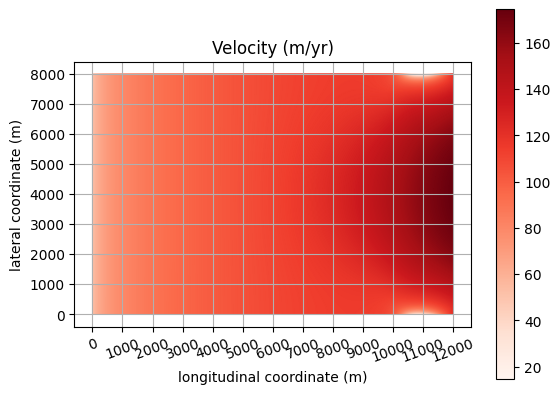

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(u_0, axes = ax, cmap = 'Reds')#, vmin = 30, vmax = 100)
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('Velocity (m/yr)')
plt.xlabel('longitudinal coordinate (m)')
plt.grid()
plt.ylabel('lateral coordinate (m)')

## Initialize remaining solvers

In [8]:
####################################
####################################
### initialize remaining solvers ###
####################################
####################################

nonconservative_transport_model = TransportEquation(field_name = 'field', conservative = False) #for nonconservative advection
nonconservative_transport_solver = TransportSolver(nonconservative_transport_model, **opts) #e.g., η, eventually damage

H = H_0.copy(deepcopy = True)
s = s_0.copy(deepcopy = True)
b = b_0.copy(deepcopy = True)
u = u_0.copy(deepcopy = True)

path = figures_path + f'viscoplastic/{nx}_{T}_{u_gl}_{coeff}_{τ_c}'

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

a_x = exp(-1/2*((x - Lx/2)/100)**2) #impose an ablation rate (m/yr) as a gaussian curve
a_y = exp(-1/2*((y - Ly/2)/100)**2)
smb = Function(Q).project(1*a_x*a_y)
smb = Function(Q).project(Constant(0))

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plot = tripcolor(smb, axes = ax, cmap = 'Reds')#, vmin = 30, vmax = 100)
# plt.colorbar(plot)
# plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
# plt.title('Velocity (m/yr)')
# plt.xlabel('longitudinal coordinate (m)')
# plt.grid()
# plt.ylabel('lateral coordinate (m)')

In [9]:
os.getcwd()

'/home/firedrake/H3F/figures/marginal_rumples/viscoplastic/360_273.15_50_0.05_10'

## Solve with firedrake

With $a$ and $L$ defined as below:

$$a = -\int_\Omega\nabla\cdot\frac{1}{12}H^3\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{*(t)}\cdot\nabla \dot{n} - \int_\Omega \dot{n}\rho_wg\dot{\eta}^{(t)}\Delta t - \int_\Omega \nabla(\dot{\eta}^{(t)}\Delta t)\cdot\nabla\cdot \left(\dot{n}H\overline{\boldsymbol{\sigma}}\right) + \int_\Omega\kappa\boldsymbol{\tau}_{\dot{\eta}/\zeta}^{(t)}:\mathbf{t} - \int_\Omega\nabla\dot{\eta}^{(t)}\cdot\nabla\cdot \left(2\overline{\nu}\mathbf{t}\right)$$

$$L = \int_\Omega \dot{n}\rho_wgh_{ab}^{(t - 1)} + \int_\Omega\nabla\eta^{(t - 1)}\cdot\nabla\cdot\left(\dot{n}H\overline{\boldsymbol{\sigma}}\right)$$

we solve the system $a - L = 0$. 

In [ ]:
for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### obtain flow field ###
    #########################
    #########################
        
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = friction, 
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s, accumulation = Constant(0))     

    s = Function(Q).project(s)
    H = Function(Q).project(s - b) #initial basal elevation
        
    ε = Function(S).project(sym(grad(u))) #strain rate tensor
    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor
    
    h_ab = Function(Q).project(s - (1 - ρ_i/ρ_w)*H)
    ϱ = Function(Q).project(1 - s/H)

    C = Function(Q).project(1/6*ν*H**3)

    q = Function(QS)
    η_dot, τ_η = split(q)
    

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    term_ids = [2]
    inflow_ids = [1]
    sidewall_ids = [3, 4]
    
    τ_term = DirichletBC(QS.sub(1), 0*Identity(2), term_ids)
    τ_gl = DirichletBC(QS.sub(1), 0*Identity(2), inflow_ids)
    η_gl = DirichletBC(QS.sub(0), 0, inflow_ids)
    η_sides = DirichletBC(QS.sub(0), 0, sidewall_ids)
    η_term = DirichletBC(QS.sub(0), -1, term_ids)
    

    J_II = sqrt(1/2*(τ_η[0, 0]**2 + τ_η[1, 1]**2) + τ_η[0, 1]**2 + τ_η[1, 0]**2) #J_II of τ_η
    α = 1/10
    κ = conditional(J_II > τ_c, (τ_c + α*(J_II - τ_c))/J_II, 1)
    
    a = -dot(div(1/12*H**3*(τ_η + tr(τ_η)*Identity(2))), grad(n_dot))*dx - n_dot*ρ_w*g*η_dot*Δt*dx - dot(grad(η_dot*Δt), div(n_dot*H*σ))*dx 
    a += κ*inner(τ_η, t)*dx - dot(grad(η_dot), div(2*ν*t))*dx
    L = n_dot*ρ_w*g*(h_ab)*dx + dot(grad(η_prev), div(n_dot*H*σ))*dx 

    # a += 1/2*1e10**2*η_dot*(M[0, 0] - M_term)*ds(2)
    # a += 1/2*(1e10)**2*(m[0, 1]*M[0, 1] + m[1, 0]*M[1, 0] + m[1, 1]*M[1, 1])*(dx + ds) #M_xy = M_yx = M_yy = 0
    # a += 1/2*1e10**2*grad(n_dot)[1]*grad(η_dot)[1]*(ds + dx) #dη/dy = 0
    # a += 1/2*1e10**2*dot(div(m)[0], div(M)[0])*ds(2) #dM_xx/dx = 0 at the terminal cliff

    try:
        solve(a - L == 0, q, bcs = [η_gl, τ_gl, η_term, η_sides])
    except:
        pass

    Δη.project(η_dot*Δt)
    η_prev.project(η_prev + Δη)
    
    s = Function(Q).project(s + Δη)
    b = Function(Q).project(b + smb*Δt + Δη)
    H = Function(Q).project(H + smb*Δt)

    η_prev = nonconservative_transport_solver.prognostic_solve(Δt, field = η_prev, velocity = u, field_inflow = η_prev,
                                                               field_accumulation = Constant(0))
    η_prev = Function(Q).project(η_prev)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    plot = tripcolor(η_prev, axes = ax, cmap = 'seismic', norm = colors.SymLogNorm(linthresh = 0.01, base=10, vmin = -10, vmax = 10))
    plt.colorbar(plot)
    plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
    plt.xlabel('longitudinal coordinate (m)')
    # plt.grid()
    plt.ylabel('lateral coordinate (m)')
    plt.savefig(f'{step}')
    plt.title(f'$t$ = {step*Δt:.2f} years', fontsize = 16)
    plt.tight_layout()
    plt.close()

 41%|███████████████████████████████▍                                            | 83/201 [9:44:09<14:14:59, 434.74s/it]

# Plot results

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(Function(Q).project(τ_η[0, 0]), axes = ax, cmap = 'Reds', vmin = 50, vmax = 100)#, vmin = -0.01, vmax = 0.01)
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('surface elevation (m)')
plt.xlabel('longitudinal coordinate (m)')
# plt.grid()
plt.ylabel('lateral coordinate (m)')

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(η_prev, axes = ax, cmap = 'seismic', vmin = -10, vmax = 10)
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('vertical deflection (m)')
plt.xlabel('longitudinal coordinate (m)')
# plt.grid()
plt.ylabel('lateral coordinate (m)')

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plot = tripcolor(Function(Q).project(M_star[0, 0]), axes = ax, cmap = 'Greens')#, vmin = -10, vmax = 10)
plt.colorbar(plot)
plt.xticks(range(0, Lx + 1, 1000), rotation = 20)
plt.title('adjusted bending moment $M^*_{xx}$ (N)')
plt.xlabel('longitudinal coordinate (m)')
plt.grid()
plt.ylabel('lateral coordinate (m)')